# AutoMM Detection - High Performance Finetune on COCO Format Dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/object_detection/finetune/detection_high_performance_finetune_coco.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/object_detection/finetune/detection_high_performance_finetune_coco.ipynb)



![Pothole Dataset](https://automl-mm-bench.s3.amazonaws.com/object_detection/example_image/pothole144_gt.jpg)


In this section, our goal is to fast finetune and evaluate a pretrained model 
on [Pothole dataset](https://www.kaggle.com/datasets/andrewmvd/pothole-detection) in COCO format.
Pothole is a single object, i.e. `pothole`, detection dataset, containing 665 images with bounding box annotations
for the creation of detection models and can work as POC/POV for the maintenance of roads.
See [AutoMM Detection - Prepare Pothole Dataset](../data_preparation/prepare_pothole.ipynb) for how to prepare Pothole dataset.

To start, let's import MultiModalPredictor:

In [1]:
!pip install autogluon.multimodal


In [2]:
from autogluon.multimodal import MultiModalPredictor

Make sure `mmcv-full` and `mmdet` are installed:

In [3]:
!mim install mmcv-full
!pip install "mmdet>=2.28, <3.0.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.12.0/index.html


And also import some other packages that will be used in this tutorial:

In [4]:
import os
import time

from autogluon.core.utils.loaders import load_zip

We have the sample dataset ready in the cloud. Let's download it:

In [5]:
zip_file = "https://automl-mm-bench.s3.amazonaws.com/object_detection/dataset/pothole.zip"
download_dir = "./pothole"

load_zip.unzip(zip_file, unzip_dir=download_dir)
data_dir = os.path.join(download_dir, "pothole")
train_path = os.path.join(data_dir, "Annotations", "usersplit_train_cocoformat.json")
val_path = os.path.join(data_dir, "Annotations", "usersplit_val_cocoformat.json")
test_path = os.path.join(data_dir, "Annotations", "usersplit_test_cocoformat.json")

While using COCO format dataset, the input is the json annotation file of the dataset split.
In this example, `usersplit_train_cocoformat.json` is the annotation file of the train split.
`usersplit_val_cocoformat.json` is the annotation file of the validation split.
And `usersplit_test_cocoformat.json` is the annotation file of the test split.

We select the VFNet with ResNet-50 as backbone, Feature Pyramid Network (FPN) as neck,
and input resolution is 640x640, pretrained on COCO dataset.
*(The neck of the object detector refers to the additional layers existing between the backbone and the head. 
Their role is to collect feature maps from different stages.)*
With this setting, it sacrifices training and inference time,
and also requires much more GPU memory,
but the performance is high. 

We use `val_metric = map`, i.e., mean average precision in COCO standard as our validation metric.
In previous section [AutoMM Detection - Fast Finetune on COCO Format Dataset](detection_fast_finetune_coco.ipynb),
we did not specify the validation metric and by default the validation loss is used as validation metric.
Using validation loss is much faster but using mean average precision gives the best performance.

And we use all the GPUs (if any):

In [15]:
checkpoint_name = "vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco"
num_gpus = -1  # use all GPUs
val_metric = "map"

We create the MultiModalPredictor with selected checkpoint name, val_metric, and number of GPUs.
We need to specify the problem_type to `"object_detection"`,
and also provide a `sample_data_path` for the predictor to infer the categories of the dataset.
Here we provide the `train_path`, and it also works using any other split of this dataset.

In [16]:
predictor = MultiModalPredictor(
    hyperparameters={
        "model.mmdet_image.checkpoint_name": checkpoint_name,
        "env.num_gpus": num_gpus,
        "env.num_workers": 0,
        "optimization.val_metric": val_metric,
    },
    problem_type="object_detection",
    sample_data_path=train_path,
)

load checkpoint from local path: yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 128, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).
size mismatch for bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([80, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 128, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).
size mismatch for bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([80, 128, 1, 1]) from checkpoint, the shape in current mo

We used `1e-4` for Yolo V3 in previous tutorial, 
but set the learning rate to be `5e-6` here, 
because larger model always prefers smaller learning rate.
Note that we use a two-stage learning rate option during finetuning by default,
and the model head will have 100x learning rate.
Using a two-stage learning rate with high learning rate only on head layers makes
the model converge faster during finetuning. It usually gives better performance as well,
especially on small datasets with hundreds or thousands of images.
We also set the batch_size to be 2, because this model is too huge to run with larger batch size.
We also compute the time of the fit process here for better understanding the speed.
We only set the number of epochs to be 1 for a quick demonstration, 
and to seriously finetune the model on this dataset we will need to set this to 20 or more.

In [17]:
import time
start = time.time()
predictor.fit(
    train_path,
    hyperparameters={
        "optimization.learning_rate": 5e-6, # we use two stage and detection head has 100x lr
        "optimization.max_epochs": 1,
        "optimization.check_val_every_n_epoch": 1, # make sure there is at least one validation
        "env.per_gpu_batch_size": 2,  # decrease it when model is large
    },
)
end = time.time()

Using default root folder: ./pothole/pothole/Annotations/... Specify `root=...` if you feel it is wrong...
Global seed set to 0
No path specified. Models will be saved in: "AutogluonModels/ag-20230524_071506/"


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


AutoMM starts to create your model. ✨

- Model will be saved to "/home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/AutogluonModels/ag-20230524_071506".

- Validation metric is "map".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/AutogluonModels/ag-20230524_071506
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

/home/ubuntu/autogluon/multimodal/src/autogluon/multimodal/utils/environment.py:73: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3: 'val_map' reached 0.02259 (best 0.02259), saving model to '/home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/AutogluonModels/ag-20230524_071506/epoch=0-step=3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/AutogluonModels/ag-20230524_071506")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/AutogluonModels/ag-20230524_071506
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tut

Print out the time and we can see that it takes a long time even for one epoch.

In [18]:
print("This finetuning takes %.2f seconds." % (end - start))

This finetuning takes 17.81 seconds.


To get a model with reasonable performance, you will need to finetune the model with more epochs.
We set `max_epochs` to 50 and trained a model offline. And we uploaded it to AWS S3. 
To load and check the result:

In [7]:
# Load Trained Predictor from S3
zip_file = "https://automl-mm-bench.s3.amazonaws.com/object_detection/checkpoints/pothole_AP50_718.zip"
download_dir = "./pothole_AP50_718"
load_zip.unzip(zip_file, unzip_dir=download_dir)
better_predictor = MultiModalPredictor.load("./pothole_AP50_718/AutogluonModels/ag-20221123_021130")
better_predictor.set_num_gpus(1)
better_predictor.set_num_workers(num_workers=0, num_workers_evaluation=0)

# Evaluate new predictor
better_predictor.evaluate(test_path)

Unzipping ./pothole_AP50_718/file.zip to ./pothole_AP50_718


load checkpoint from local path: yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth


/home/ubuntu/autogluon/multimodal/src/autogluon/multimodal/models/mmdet_image.py:136: UserWarning: Using classes provided in checkpoints: ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush').

processing vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco...
vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-6879c318.pth exists in /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune


/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.logging')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references

Successfully dumped vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco.py to /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune


/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.logging')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references

processing vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco...
vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-6879c318.pth exists in /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune


/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/ubuntu/.conda/envs/autogluon/lib/python3.9/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.logging')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references

Successfully dumped vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco.py to /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune


Load pretrained checkpoint: /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/pothole_AP50_718/AutogluonModels/ag-20221123_021130/model.ckpt
Using default root folder: ./pothole/pothole/Annotations/... Specify `root=...` if you feel it is wrong...
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: 0it [00:00, ?it/s]

/home/ubuntu/.local/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
A new predictor save path is created.This is to prevent you to overwrite previous predictor saved here.You could check current save path at predictor._save_path.If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20230525_002747/"


saving file at /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/AutogluonModels/ag-20230525_002747/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

{'map': 0.44950797639571893,
 'mean_average_precision': 0.44950797639571893,
 'map_50': 0.7175372733998941,
 'map_75': 0.4829620606505225,
 'map_small': 0.24602313385522148,
 'map_medium': 0.45880056005378184,
 'map_large': 0.6057050104503202,
 'mar_1': 0.25486725663716814,
 'mar_10': 0.5563421828908555,
 'mar_100': 0.6342182890855457,
 'mar_small': 0.5267605633802817,
 'mar_medium': 0.6209944751381216,
 'mar_large': 0.7494252873563219}

We can get the prediction on test set:

In [10]:
pred = better_predictor.predict(test_path)

Using default root folder: ./pothole/pothole/Annotations/... Specify `root=...` if you feel it is wrong...
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: 0it [00:00, ?it/s]

A new predictor save path is created.This is to prevent you to overwrite previous predictor saved here.You could check current save path at predictor._save_path.If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20230524_235846/"


saving file at /home/ubuntu/autogluon/docs/tutorials/multimodal/object_detection/finetune/AutogluonModels/ag-20230524_235846/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Let's also visualize the prediction result:

In [21]:
!pip install opencv-python

Saved visualizations to ./


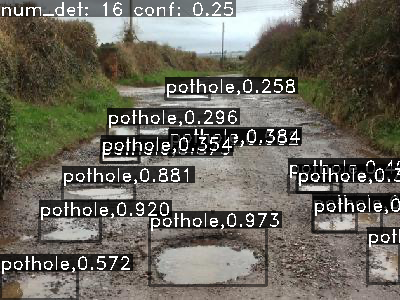

In [22]:
from autogluon.multimodal.utils import visualize_detection
conf_threshold = 0.25  # Specify a confidence threshold to filter out unwanted boxes
visualization_result_dir = "./"  # Use the pwd as result dir to save the visualized image
visualized = visualize_detection(
    pred=pred[12:13],
    detection_classes=predictor.get_predictor_classes(),
    conf_threshold=conf_threshold,
    visualization_result_dir=visualization_result_dir,
)
from PIL import Image
from IPython.display import display
img = Image.fromarray(visualized[0][:, :, ::-1], 'RGB')
display(img)

Under this high performance finetune setting, it took a long time to train but reached `mAP = 0.450, mAP50 = 0.718`!
For how to finetune faster,
see [AutoMM Detection - Fast Finetune on COCO Format Dataset](detection_fast_finetune_coco.ipynb), where we finetuned a YOLOv3 model with lower
performance but much faster.

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../../advanced_topics/customization.ipynb).

## Citation

```
@article{DBLP:journals/corr/abs-2008-13367,
  author    = {Haoyang Zhang and
               Ying Wang and
               Feras Dayoub and
               Niko S{\"{u}}nderhauf},
  title     = {VarifocalNet: An IoU-aware Dense Object Detector},
  journal   = {CoRR},
  volume    = {abs/2008.13367},
  year      = {2020},
  url       = {https://arxiv.org/abs/2008.13367},
  eprinttype = {arXiv},
  eprint    = {2008.13367},
  timestamp = {Wed, 16 Sep 2020 11:20:03 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-2008-13367.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
```
